# CrackNet - Development Notebook (Keras)

Implementation in Keras of the CNN described in Deep Learning-based Crack Detection Using Convolutional Neural Network and Naıve Bayes Data Fusion. [1]

<img src="original_paper_cnn.png">

## References

- [1] Chen, Fu-Chen & Jahanshahi, Mohammad. (2017). NB-CNN: Deep Learning-based Crack Detection Using Convolutional Neural Network and Naïve Bayes Data Fusion. IEEE Transactions on Industrial Electronics. PP. 1-1. 10.1109/TIE.2017.2764844.

In [1]:
import sys
WORKSPACE_BASE_PATH="/Users/anup.sharma/repos/Garudltd/tensorflow-crack-classification" # Parent directory containing src, checkpoints, models, etc.
CODE_BASE_PATH="/Users/anup.sharma/repos/Garudltd/tensorflow-crack-classification/src/" # Path were components are stored.
DATA_BASE_PATH="/Users/anup.sharma/repos/Garudltd/tensorflow-crack-classification/data/" # Directory with data in case it is not inside WORKSPACE BASE path.
sys.path.append(CODE_BASE_PATH)

In [2]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ELU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard

from IPython.display import SVG
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

## Model definition

- Differences with original paper:
    - Regularization
    - Conv4 layer. Paper says (2,2), changed to (3,3).

In [3]:
def build_cracknet(input_shape=(120,120,3),n_output_classes=2):    
    model = Sequential()
    
    #bias_regularization = 0.0001
    #kernel_regularization = 0.0001
    
    # Convolution + Batch Norm. + ELU + Pooling #1  
    model.add( 
        Conv2D( 32, (11, 11), 
               input_shape=input_shape, 
               activation = 'relu', 
               strides=(1,1), 
               name="Conv1"
               #kernel_regularizer=l2(kernel_regularization),
               #bias_regularizer=l2(bias_regularization)
        ) ) 
    model.add( BatchNormalization( name="Conv1BN"))
    model.add( ELU( name="Conv1ELU" ))
    model.add( MaxPooling2D(pool_size = (7,7),strides=(2,2), name="Conv1Pool" ) )
    
    # Convolution + Batch Norm. + ELU + Pooling #2
    model.add( 
        Conv2D( 48, (11, 11), 
               input_shape=(52,52,32), 
               activation = 'relu', 
               strides=(1,1), name="Conv2"
               #kernel_regularizer=l2(kernel_regularization),
               #bias_regularizer=l2(bias_regularization)
        ) )
    model.add( BatchNormalization( name="Conv2BN" ))
    model.add( ELU( name="Conv2ELU" ))
    model.add( MaxPooling2D(pool_size = (5,5),strides=(2,2), name="Conv2Pool" ) )
    
    # Convolution + Batch Norm. + ELU + Pooling #3
    model.add(
        Conv2D( 64, (7,7), 
                input_shape=(19,19,48),
                activation = 'relu', 
                strides=(1,1), 
                name="Conv3"
                #kernel_regularizer=l2(kernel_regularization),
                #bias_regularizer=l2(bias_regularization)
    ) )
    model.add(BatchNormalization(name="Conv3BN"))
    model.add(ELU( name="Conv3ELU"))
    model.add( MaxPooling2D(pool_size = (3,3),strides=(1,1), name="Conv3Pool" ) ) 
    
    # Convolution + Batch Norm. + ELU + Pooling #4
    model.add(
        Conv2D( 80, (5,5), 
               activation = 'relu', 
               strides=(1,1), 
               name="Conv4"
               #kernel_regularizer=l2(kernel_regularization),
               #bias_regularizer=l2(bias_regularization
              )
        )
    model.add(BatchNormalization( name="Conv4BN" ))
    model.add(ELU( name="Conv4ELU" ))
    model.add( MaxPooling2D(pool_size = (3,3),strides=(1,1), name="Conv4Pool" ) ) # Paper says (2,2) ?
    
    # Flattening
    model.add( Flatten() )
    
    # FC #1
    model.add( Dense( units = 5120, input_shape=(96,), activation = 'relu', ) )
    model.add(ELU())
    model.add(Dropout(0.2))
    
    # FC #2
    model.add( Dense( units = 96, input_shape=(2,), activation = 'relu' ) )   
    
    # Output Layer
    model.add( Dense( units = n_output_classes, activation = 'softmax' ) )   
    
    # Compile
    sgd_optimizer = SGD(lr=0.002, decay=0.1/350, momentum=1)
    model.compile( optimizer = sgd_optimizer, 
                        loss = 'categorical_crossentropy', 
                        metrics = ['accuracy'] )
    return model


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 110, 110, 32)      11648     
_________________________________________________________________
Conv1BN (BatchNormalization) (None, 110, 110, 32)      128       
_________________________________________________________________
Conv1ELU (ELU)               (None, 110, 110, 32)      0         
_________________________________________________________________
Conv1Pool (MaxPooling2D)     (None, 52, 52, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 42, 42, 48)        185904    
_________________________________________________________________
Conv2BN (BatchNormalization) (None, 42, 42, 48)        192       
_________________________________________________________________
Conv2ELU (ELU)               (None, 42, 42, 48)        0

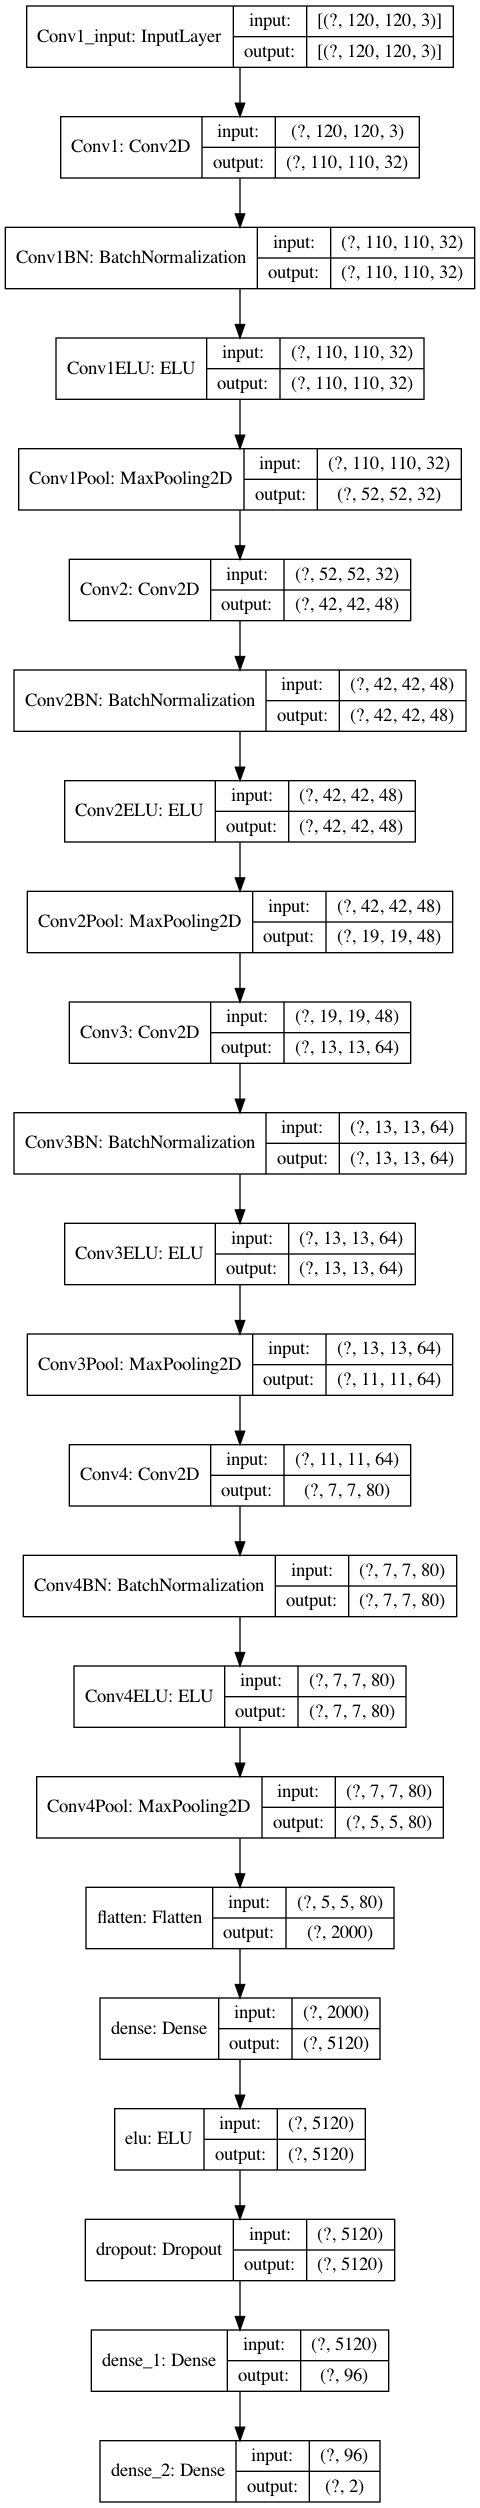

In [4]:
model = build_cracknet()
model.summary()
plot_model(model, show_shapes=True)

## Training

- Differences with original paper:
    - Dataset
        - Normalization
        - Augmentation

In [5]:
def train_cracknet( model,
               target_size,
               dataset_path,
               training_path_prefix,
               test_path_prefix,                        
               history_file_path,
               history_filename,
               checkpoint_path,
               checkpoint_prefix,
               number_of_epochs,
               tensorboard_log_path
            ):
    """
        see: https://keras.io/preprocessing/image/
    """
    train_datagen = ImageDataGenerator( rescale=1./255,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True )
        
    test_datagen = ImageDataGenerator(rescale=1./255)
    training_set_generator = train_datagen.flow_from_directory(
            dataset_path+training_path_prefix,
            target_size,
            batch_size=32,
            class_mode='categorical',
            shuffle=True,
            seed=42
        )
    test_set_generator = test_datagen.flow_from_directory(
            dataset_path+test_path_prefix,
            target_size,
            batch_size=32,
            class_mode='categorical',
            shuffle=True,
            seed=42
        )
        
    step_size_train=training_set_generator.n//training_set_generator.batch_size
    step_size_validation=test_set_generator.n//test_set_generator.batch_size

    check_pointer = ModelCheckpoint(
            checkpoint_path + '%s_weights.{epoch:02d}-{val_loss:.2f}.hdf5' % checkpoint_prefix, 
            monitor='val_loss', 
            mode='auto', 
            save_best_only=True
    )
    
    tensorboard_logger = TensorBoard( 
        log_dir=tensorboard_log_path, histogram_freq=0,  
          write_graph=True, write_images=True
    )
    tensorboard_logger.set_model(model)

    csv_logger = CSVLogger(filename=history_file_path+history_filename)
    history = model.fit_generator(
            training_set_generator,
            steps_per_epoch=step_size_train,
            epochs=number_of_epochs,
            validation_data=test_set_generator,
            validation_steps=step_size_validation,
            callbacks=[check_pointer, csv_logger,tensorboard_logger] 
    )

In [6]:
MODEL_NAME="cracknet_cracks8020"

In [7]:
train_cracknet(  model,
            target_size=(120,120),
            dataset_path=DATA_BASE_PATH+"datasets/cracks_splitted8020/",
            training_path_prefix="train_set",
            test_path_prefix="test_set",
            history_file_path=WORKSPACE_BASE_PATH+"/training_logs/",
            history_filename=MODEL_NAME+".csv",
            checkpoint_path=WORKSPACE_BASE_PATH+"/model-checkpoints/",
            checkpoint_prefix=MODEL_NAME,
            number_of_epochs=30, # Original paper: 70 epochs / 32.535 seconds
            tensorboard_log_path=WORKSPACE_BASE_PATH+"/tensorboard_logs/",
)

Found 32158 images belonging to 2 classes.
Found 7261 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
   1/1004 [..............................] - ETA: 0s - loss: 0.6856 - accuracy: 0.5000WARNING:tensorflow:From /Users/anup.sharma/.pyenv/versions/3.7.6/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
  55/1004 [>.............................] - ETA: 14:23 - loss: 0.2986 - accuracy: 0.9028

KeyboardInterrupt: 

## Training Report

In [13]:
import matplotlib
from utils.plotutils import plot_learning_curves_from_history_file
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 6)
fig = plot_learning_curves_from_history_file(WORKSPACE_BASE_PATH+"/training_logs/"+MODEL_NAME+".csv")

ModuleNotFoundError: No module named 'pandas'

## Export model to SavedModelFormat

In [15]:
import glob
import os

list_of_files = glob.glob(WORKSPACE_BASE_PATH+'/model-checkpoints/*.hdf5') 
CHECKPOINT_FILE = max(list_of_files, key=os.path.getctime) # last checkpoint
VERSION=1
print(CHECKPOINT_FILE)

/Users/anup.sharma/repos/Garudltd/tensorflow-crack-classification/model-checkpoints/cracknet_cracks8020_weights.13-0.69.hdf5


In [16]:
from utils.export_tools import convert_from_keras_to_savedmodel

convert_from_keras_to_savedmodel(
    input_filename=CHECKPOINT_FILE,
    export_path=WORKSPACE_BASE_PATH+'/models/'+MODEL_NAME+"/"+str(VERSION)
)

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


AttributeError: module 'tensorflow.keras.backend' has no attribute 'get_session'